Se usa regresión lineal por mínimos cuadrados.

In [1]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn import linear_model
from ggplot import *
reg = linear_model.LinearRegression()
df = pd.read_csv("training.txt") # El set de entrenamiento como dataframe de pandas
test = pd.read_csv("blogData_test-2012.02.01.00_00.csv") # El set de prueba

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


La última columna de los sets son las respuestas, entonces las separamos.

In [2]:
y_test = test.iloc[:,test.shape[1]-1] 
w_test = test.iloc[:,0:test.shape[1]-1]

Le quité los primeros 50 elementos porque no me gustaron. Y después se los volví a poner y mejoró bastante\* el modelo.

\*De un error cuadrático de 920 a 486

In [3]:
w = df.iloc[:,0:df.shape[1]-1]
y = df.iloc[:,df.shape[1]-1]

Se ajusta el modelo.

In [4]:
reg.fit(w,y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Genera una predicción, con los datos de prueba.

In [5]:
y_pred = reg.predict(w_test)


In [6]:
mse = mean_squared_error(y_test, y_pred)
print("El error cuadratico es: %.3f" % mse)

El error cuadratico es: 486.507


Echándole un vistazo a los resultados de la predicción, noté que algunos valores eran negativos, lo cual no tiene sentido en el problema pues no hay número negativo de comentarios. Entonces, a pesar de que no se puede cambiar el modelo _per se_ podemos cambiar los valores de la predicción para que cada valor negativo sea reemplazado por un cero.

In [7]:
for x, value in np.ndenumerate(y_pred):
    if value < 0:
        y_pred[x] = 0

In [8]:
mse_zeros = mean_squared_error(y_test, y_pred)
print("Error cuadratico original: %.3f\nError cuadratico con reemplazo de valores negativos: %.3f" % (mse, mse_zeros))

Error cuadratico original: 486.507
Error cuadratico con reemplazo de valores negativos 468.119


Genial, sí mejoró. Ahora probemos con otro set.

In [10]:
test2 = pd.read_csv("blogData_test-2012.02.02.00_00.csv")
res2 = test2.iloc[:,test2.shape[1]-1]
test2 = test2.iloc[:,0:test2.shape[1]-1]
y_pred2 = reg.predict(test2)
print("Error cuadratico original: %.3f" % mean_squared_error(res2, y_pred2))
for x, value in np.ndenumerate(y_pred2):
    if value < 0:
        y_pred2[x] = 0
        
print("Error cuadratico con reemplazo de valores negativos %.3f" % mean_squared_error(res2, y_pred2))

Error cuadratico original: 272.204
Error cuadratico con reemplazo de valores negativos 259.095


También funciona y el error para este set es ~~poco menos de una tercera parte~~ poco más de la mitad del anterior\*, lo cual nos dan confianza de que el modelo es bueno. (\*Era una tercera parte cuando quité los primeros cincuenta campos de cada elemento.)

Ahora, aprovechando que sabemos cómo visualizar altas dimensiones en dos, podemos ver si realmente existe una tendencia en los datos o solo estamos sacando números sin sentido.

In [11]:
from sklearn import manifold
n_points = 4000
rndperm = np.random.permutation(df.shape[0])
tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.iloc[rndperm[:n_points],:].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.112s...
[t-SNE] Computed neighbors for 4000 samples in 3.496s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 17.376745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.647240
[t-SNE] Error after 300 iterations: 1.036101


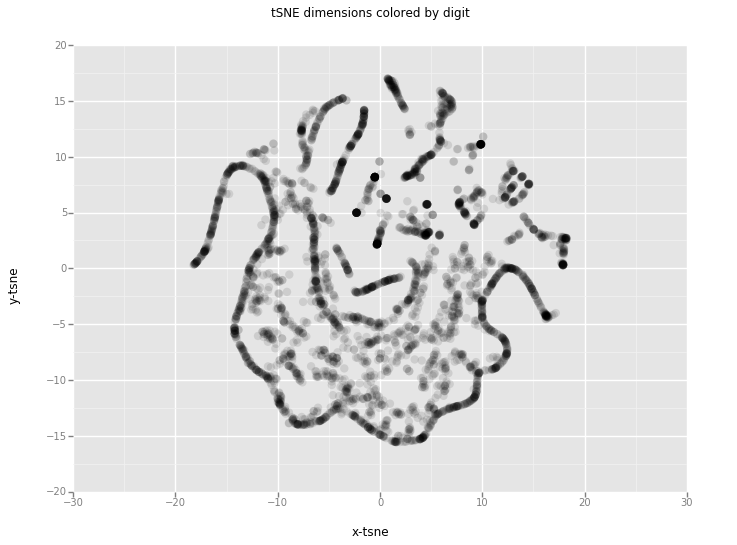

<ggplot: (280994501)>

In [12]:
df_tsne = df.iloc[rndperm[:n_points],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

Por cómo funciona *T-SNE* creo que podemos tener certeza de que los datos si pueden ser ajustados a un modelo de manera confiable.